In [1]:
import numpy as np
#from scipy import optimize
#from scipy.misc import derivative
import matplotlib.pyplot as plt
#import pickle 
from sklearn.preprocessing import normalize

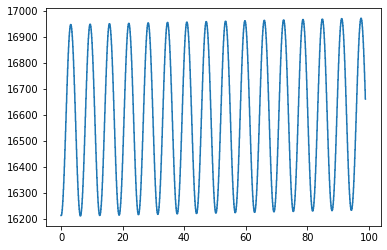

In [8]:
#slit position
def slit(t, s, omega):
    return -h-s*np.cos(omega*t)

#slit velocity
def der_slit(t, s, omega):
    return s*np.sin(omega*t)*omega
    
#ball position
def ball(t, y, v, t0):
    return (y+(v*(t-t0)))

#difference between position of ball and slit
def coll(t, y, v, t0, s, omega):
    return (slit(t, s, omega)-ball(t, y, v, t0))

#derivative of the above function
def der_coll(t, v,  s, omega):
    return der_slit(t, s, omega) - v

#root finding function
def rtsafe(x1, x2, y, v, t, s, omega, xacc=0.0001, maxit = 100):
    fl = coll(x1, y, v, t, s, omega)
    fh = coll(x2, y, v, t, s, omega)
    if (fl>0 and fh>0) or (fl<0 and fh<0):
        print ('root not bracketed')
    if fl==0:
        rtsafe = x1
        return rtsafe
    
    elif fh==0:
        rtsafe = x2
        return rtsafe
    
    elif fl<0:
        xl = x1
        xh = x2

    else:
        xh = x1
        xl = x2

    rtsafe = 0.5*(x1+x2)
    dxold = abs(x2-x1)
    dx = dxold

    f = coll(rtsafe, y, v, t, s, omega)
    df = der_coll(rtsafe, v, s, omega)
    j = 1
    while j<maxit:
        if (((rtsafe-xh)*df-f)*((rtsafe-xl)*df-f))>0 or (abs(2.*f) > abs(dxold*df)):
            dxold = dx
            dx = 0.5*(xh-xl)
            rtsafe = xl+dx
            if xl == rtsafe:
                return rtsafe
        else:
            dxold = dx
            dx = f/df
            temp = rtsafe
            rtsafe = rtsafe-dx
            if temp == rtsafe:
                return rtsafe
        if (abs(dx)  < xacc):
            return rtsafe
        
        f = coll(rtsafe, y, v, t, s, omega)
        df = der_coll(rtsafe, v,  s, omega)

        if (f < 0 ):
            xl = rtsafe
        else:
            xh = rtsafe
    
        j += 1
    print("steps exceeded")
    return None


def trapezium_enclosure(x, y , u, v, t, lam, l, h, s, omega):
    if v<0:
        print('moving the other direction')
    st = 'en'
    vel_vec = np.array([u, v])
    
    if u == 0:
        m = np.inf
    else:
        m = v/u
    slope = 1
    wall_y_left = h
    wall_y_right = slope*(2*l)+h
    while True:
        ball_y_right = m*(l-x)+y 
        ball_y_left = m*(-l-x)+y 
        if m == slope:
            x_int = 3
        else:
            x_int = (h-y+(slope*l)+(m*x))/(m-slope)
        #print(x_int)
        if ((-l<x_int) and (x_int<l)) and st != "sl" :
            #print('slop')
            xf = x_int
            yf = m*(xf-x)+y
            nor_vec = normalize(np.array([1, -(1/slope)]).reshape(2,1))
            st = "sl"
        elif h < ball_y_right < wall_y_right and st != "ve":
            #hit vertical
            #print('vert')
            xf = l
            yf = ball_y_right
            nor_vec = normalize(np.array([-1, 0]).reshape(2,1))
            st = "ve"

        else:
            #print('exit')
            yf = h
            xf = x + ((h-y)/vel_vec[1])* vel_vec[0]
            t += (h-y)/vel_vec[1]
            if vel_vec[1]>0:
                print('other way:', (h-y)/vel_vec[1])
            return (xf, yf, vel_vec[0], vel_vec[1], t)
                
        t += (xf-x)/vel_vec[0]
        vel_vec = vel_vec.reshape(2,1)
        ref = np.array(vel_vec - (2*np.dot(np.transpose(nor_vec), vel_vec)*nor_vec))
        ref = ((np.linalg.norm(vel_vec)/np.linalg.norm(ref))*ref).reshape(2, 1)
        if np.linalg.norm(vel_vec) - np.linalg.norm(ref)> 1e-5:
            print('unnormalized collision')
        x = xf
        y = yf
        vel_vec = np.array(ref)
        #print(ref)
        m = float(ref[1]/ref[0])
        


#mapping function from one state to the next  
def trapezium_travel(x, y , u, v, t, lam, l, h, s, omega):
    lt = (-l - x)/u #time it would take to hit left wall
    rt = (l-x)/u    #time it would take to hit right wall
    ut = (h-y)/v    #time it would take to hit top wall which 
                    #is in contact with the semi-circle enclosure.
    dt = (-h-y)/v   #time it would take to hit bottom wall
    time_step = [lt, rt, ut, dt] #feeding it into an array
    #print('t_left:',time_step[0], 't_right:',time_step[1], 
    #       't_top:',time_step[2], 't_bottom:',time_step[3])
    
    #mechanism to find the lowest positive number
    for n, i in enumerate(time_step):
        if i<=0:
            time_step[n] = 10000000
    di = np.argmin(time_step) #index of the lowest positive number
    tf = t + time_step[di] #time at which the next wall would be hit

    # if the collision is with left or right wall
    if di==0 or di == 1:
        uf = -u
        vf = v
        yf = y + v*time_step[di]
        if abs(yf)>(h+s):
            print('glitch: yf', yf, 'y', y, 'v', v, 'dt:', time_step[di])
        elif di==0:
            xf = -l
            #print('next wall: left')
        else:
            xf = l
            #print('next wall: right')
    
    #if collision is with top or bottom wall
    if di==2 or di==3:
        if di==2:
        
            yf = h
            xf = x + u*time_step[di]
            #print('next wall: trapezium enclosure')
            (xf, yf , uf, vf, tf) = trapezium_enclosure(xf, yf , u, v, tf, lam, l, h, s, omega)
            if (yf != h) or (abs(xf)>l):
                print('glitch2:', 'x:', xf, 'y:', yf, 'u:', uf, 'v:', vf) 
            
        else:
            #print('bottom bar')
            tf1 = tf + (3*s/v)
            tf2 = tf - (3*s/v)
            xf1 = x + u*time_step[di]
            if (coll(tf1, y, v, t, s, omega)*coll(tf2, y, v, t, s, omega))<0:
                root = rtsafe(tf1, tf2,y, v, t, s, omega, xacc=0.0000001, maxit = 100)
                #print('f at root:',coll(root, y, v, t, s, omega))
                if root>tf2 or root<tf1:
                    print("glitch2:",  'tf1', tf1,' tf2', tf2 , 'root:', root)
                dd = der_slit(root ,s , omega) #velocity of slit
                vf = (2*dd) - v
                y_coll = slit(root ,s , omega)
                tf2 = root + ((-h-y_coll)/vf)
                xf = xf1 + u*(tf2-root)
                uf = u
                sign = np.sign(xf)
                if abs(xf)>l:
                    x_left = abs(xf - (sign*l))
                    quo = x_left//(2*l)
                    rem = x_left%(2*l)
                    if quo%2 == 1:
                        xf = sign*(rem-l)
                    elif quo%2 == 0:
                        xf = sign*(l-rem)
                        uf = -u
                yf = -h
            else:
                print('root out of bounds')
                
            
    return (xf, yf, uf, vf, tf)

def iteration(xi, yi, ui, vi, omega, lam, l, h, s, ni, t=0):
    state_tup = (xi, yi, ui, vi, t)
    #print('x =', state_tup[0], 'y=', state_tup[1], 
    #         'u=', state_tup[2], 'v=', state_tup[3], 't=', state_tup[4])
    states  = []
    states.append(state_tup)
    k = 0
    while k<ni:
        (x, y, u, v, tf) = trapezium_travel(xi, yi , ui, vi, t, lam, l, h, s, omega)
        state_tup = (x, y, u, v, tf)
        #print('\nx =', state_tup[0], 'y=', state_tup[1], 
        #      'u=', state_tup[2], 'v=', state_tup[3], 't=', state_tup[4])
        states.append(state_tup)
        (xi, yi, ui, vi, t) = (x, y, u, v, tf)
        k += 1
    n_osc = int((omega*t)/(2*np.pi))
    #print(n_osc)
    return states


def plot_bill(states):
    #xs = []
    #ys = []
    es = []
    ts = []
    for i in states:
        (x, y, u, v, t) = i
        es.append((v**2)+(u**2))
        #xs.append(x)
        #ys.append(y)
        ts.append(t)
    #plt.scatter(xs, ys)
    #plt.xlim(-20, 20)
    #plt.ylim(-10, 10)
    #plt.show()
    plt.plot(ts, es)
    plt.show()

omega=1
lam=1
ui= 4*omega/np.pi
vi= 100*ui
l = 0.5
h= 2
s = 0.1
res = iteration(xi =-0.20, yi=-0.65, ui = ui, 
                vi =vi,
                omega=omega, lam=lam, l=l, h=h,s = s, 
                ni=10000)
plot_bill(res)



In [12]:
def save_ensemble_states(ui= ((4*lam*omega)/np.sqrt(5)),
                vi=(41*((4*lam*omega)/np.sqrt(5))), 
                omega=(2*np.pi/70), 
                lam=1, l=2, h=1,s = 0.1,  ni=10000, 
                ensemble_size = 100):
    k = 0
    systems = []
    while k<ensemble_size:
        res = iteration(xi = np.random.uniform(-l,l), 
                        yi= np.random.uniform(-h,h),
                        ui= ui,
                vi=vi, omega=omega, 
                lam=lam, l=l, h=h,s = s,  ni=ni)
        systems.append(res)
        k+=1
        print(k)
    return systems
      
    # source, destination 
                   
omega=1
lam=1
ui= 4*omega/np.pi
vi= 100*ui
l = 0.5
h= 2
s = 0.1



systems = save_ensemble_states(ui= ui,
                vi=vi, 
                omega=omega, 
                lam=lam, l=l, h=h,s = s, ni=100000)
#np.save('stadium_100.npy', systems)   

print('saved!!')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
saved!!


In [13]:
tfs = []
for i in systems:
    last_state = i[len(i)-1]
    print(last_state)
    (x, y, u, v, tm) = last_state
    tfs.append(tm)

tf = min(tfs)
print(tf)

(0.5, array([1.44520922]), array([-91.71915964]), array([-91.76918714]), array([984.87622646]))
(0.5, array([1.16945899]), array([-91.78343687]), array([-91.83327895]), array([984.81748512]))
(-0.5, array([-0.24206748]), array([91.7376439]), array([-91.78754902]), array([984.88952632]))
(-0.5, array([-0.1620616]), array([91.82697431]), array([-91.87639094]), array([984.80196941]))
(0.5, array([0.41039852]), array([-91.66624597]), array([91.51688424]), array([984.99160718]))
(array([-0.09800157]), 2, array([-91.58770955]), array([-91.63759961]), array([985.0017353]))
(0.5, array([0.44386232]), array([-91.72993789]), array([-91.77986958]), array([984.88156681]))
(-0.5, array([1.54865687]), array([91.6818366]), array([91.53222764]), array([984.98497569]))
(-0.5, array([-0.6438176]), array([91.64937803]), array([91.50029632]), array([984.997589]))
(array([-0.27456832]), -2, array([-91.85252359]), array([91.70259062]), array([984.7974887]))
(-0.5, array([1.30291368]), array([91.58519969]), 

11
21
31
41
51
61
71
81
91
101
111
121
131
141
151
161
171
181
191
201
211
221
231
241
251
261
271
281
291
301
311
321
331
341
351
361
371
381
391
401
411
421
431
441
451
461
471
481
491
501
511
521
531
541
551
561
571
581
591
601
611
621
631
641
651
661
671
681
691
701
711
721
731
741
751
761
771
781
791
801
811
821
831
841
851
861
871
881
891
901
911
921
931
941
951
961
971
981
[array([1637329.35822629]), array([1657130.02843321]), array([1679007.73810355]), array([1624998.95350227]), array([1695558.69403614]), array([1631547.31975478]), array([1668538.96131388]), array([1671424.13101795]), array([1631279.30021797]), array([1697058.70637684]), array([1627484.67569198]), array([1678722.65038649]), array([1663077.06444823]), array([1639936.33929109]), array([1695871.69212034]), array([1625810.5935829]), array([1688249.04855876]), array([1654008.42157258]), array([1649239.28610111]), array([1692843.12056568]), array([1626308.51995318]), array([1695758.63666569]), array([1646794.35182331

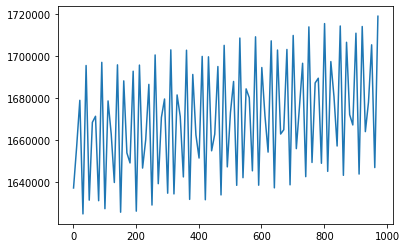

In [14]:
def load_and_plot(time_step=1):
    t = 1
    vels = []
    ts = []
    while t<tf:
        v = 0
        for i in systems:
            for n, j in enumerate(i[0:(len(i)-1)]):
                #print(i,j)
                (x1, y1, u1, v1, t1) = j
                (x2, y2, u2, v2, t2) = i[n+1]
                if t<=t2 and t>=t1:
                    v += ((u1)**2+(v1)**2)
                    break
        vels.append(v)
        ts.append(t)
        t += time_step
        print(t)
        #print(v)
    print(vels)
    print(ts)
    
    plt.plot(ts, vels)
    plt.show()
   
        

load_and_plot(time_step=10)